## Dragon Real Estate - Price Predictor

In [1]:
# Import necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from joblib import dump, load

In [2]:
housing = pd.read_csv("data.csv")

In [3]:
housing.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,5.33,36.2


In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       501 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    int64  
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(11), int64(3)
memory usage: 55.5 KB


In [5]:
housing['CHAS'].value_counts()

CHAS
0    471
1     35
Name: count, dtype: int64

In [6]:
housing.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,501.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284341,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.705587,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.884000,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208000,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.625000,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


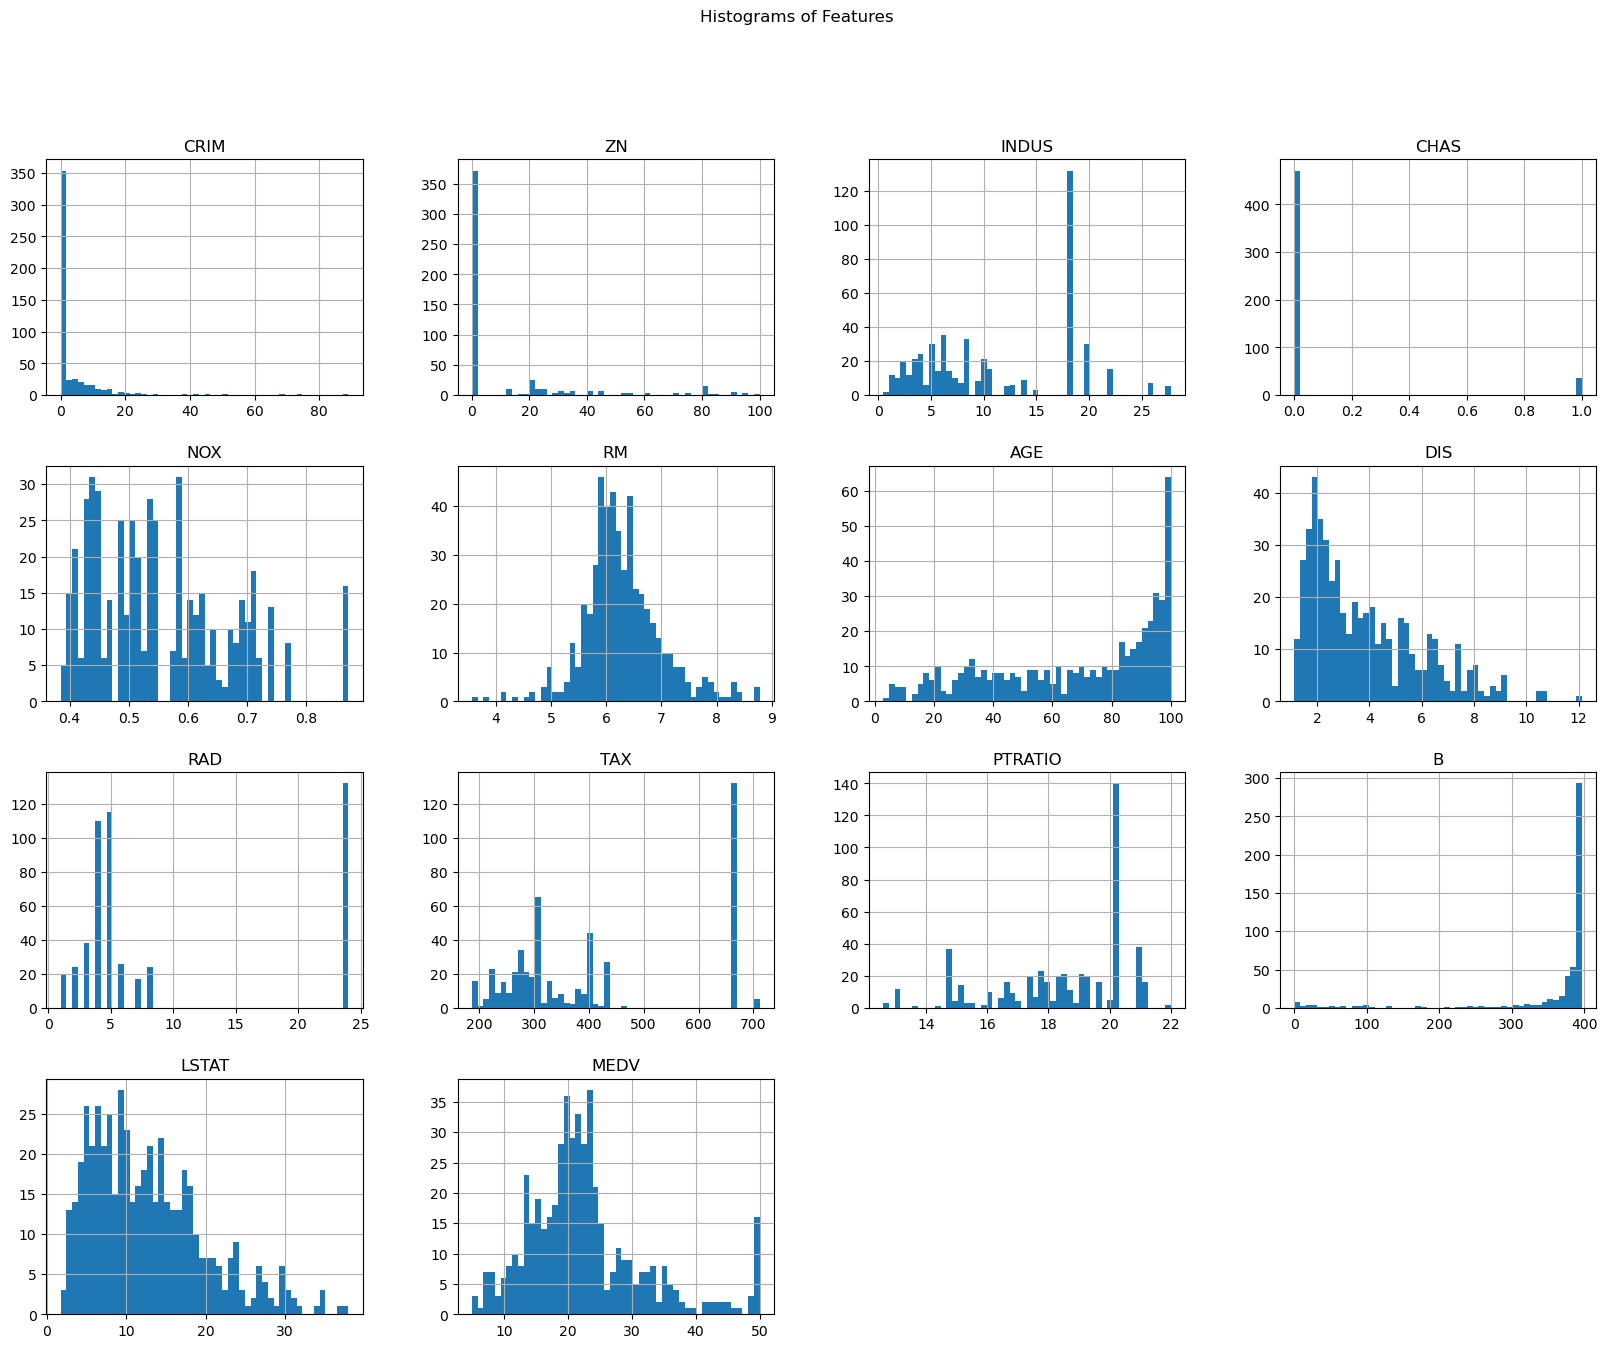

In [7]:
# Visualize data distributions and correlations (optional, for better understanding)
# Plot histograms for all numeric features
housing.hist(bins=50, figsize=(20, 15))
plt.suptitle('Histograms of Features')
plt.show()

In [8]:
# Compute correlation matrix
corr_matrix = housing.corr()  # Calculate correlation matrix
corr_with_medv = corr_matrix['MEDV'].sort_values(ascending=False)  # Sort correlations with 'MEDV'
print(corr_with_medv)

MEDV       1.000000
RM         0.696169
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: MEDV, dtype: float64


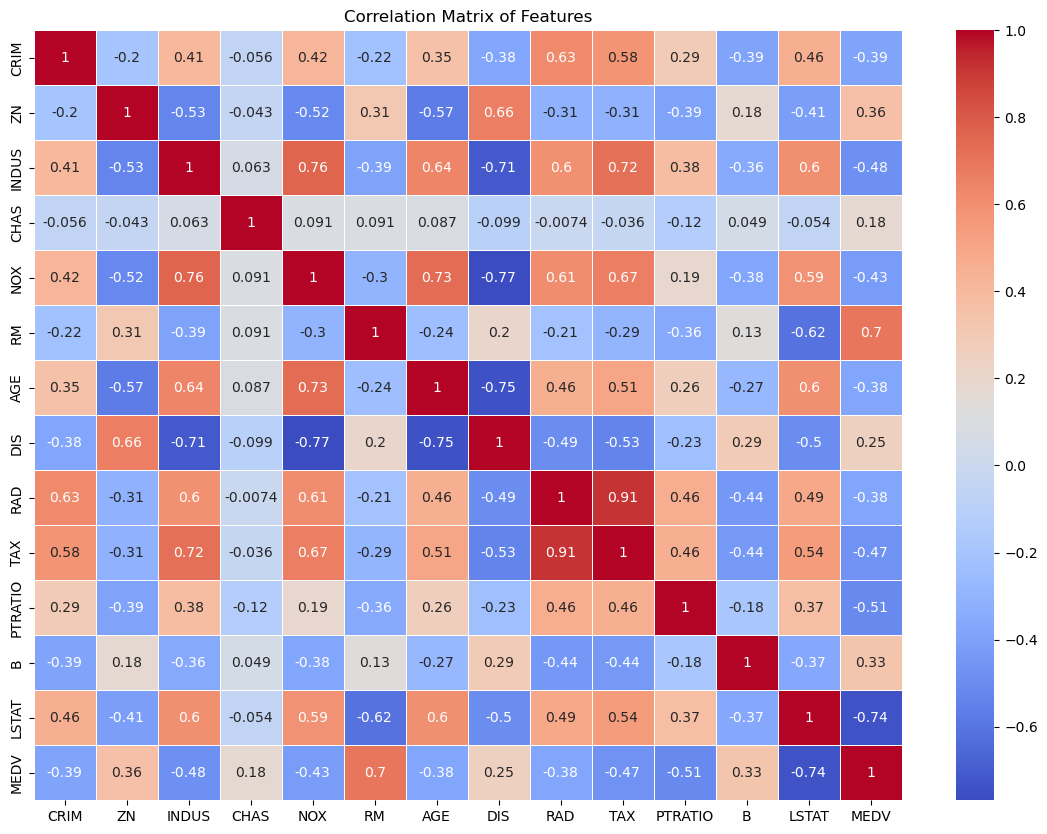

In [9]:
# Plot the correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = housing.corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

## Train-Test Splitting

In [10]:
# For learning purpose
import numpy as np
def split_train_test(data, test_ratio):
    np.random.seed(42)
    shuffled = np.random.permutation(len(data))
    print(shuffled)
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled[:test_set_size]
    train_indices = shuffled[test_set_size:] 
    return data.iloc[train_indices], data.iloc[test_indices]

In [11]:
# train_set, test_set = split_train_test(housing, 0.2)

In [12]:
# print(f"Rows in train set: {len(train_set)}\nRows in test set: {len(test_set)}\n")

In [13]:
# from sklearn.model_selection import train_test_split
# train_set, test_set  = train_test_split(housing, test_size=0.2, random_state=42)
# print(f"Rows in train set: {len(train_set)}\nRows in test set: {len(test_set)}\n")

In [14]:
# Stratified split of data based on 'CHAS' column
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing['CHAS']):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [15]:
strat_test_set['CHAS'].value_counts()

CHAS
0    95
1     7
Name: count, dtype: int64

In [16]:
strat_train_set['CHAS'].value_counts()

CHAS
0    376
1     28
Name: count, dtype: int64

In [17]:
95/7

13.571428571428571

In [18]:
376/28

13.428571428571429

In [19]:
# Separate features (X) and labels (y)
housing = strat_train_set.drop("MEDV", axis=1)  # Drop the target variable 'MEDV' from the training set
housing_labels = strat_train_set["MEDV"].copy()  # Keep the target variable separately

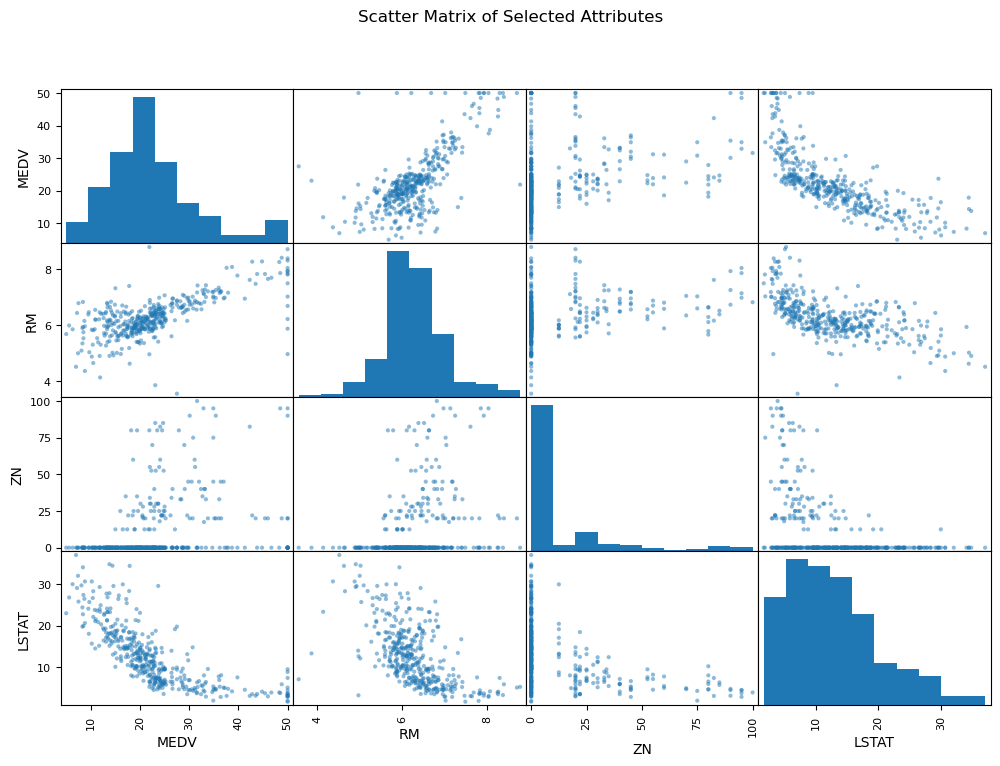

In [20]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

# Choose a subset of attributes to analyze
attributes = ["MEDV", "RM", "ZN", "LSTAT"]

# Use strat_train_set instead of housing for scatter plot matrix
scatter_matrix(strat_train_set[attributes], figsize=(12, 8))
plt.suptitle('Scatter Matrix of Selected Attributes')
plt.show()


## Missing Attributes

In [21]:
# To take care of missing attributes, you have three options:
#     1. Get rid of the missing data points
#     2. Get rid of the whole attribute
#     3. Set the value to some value(0, mean or median)

In [22]:
a = housing.dropna(subset=["RM"]) #Option 1
a.shape
# Note that the original housing dataframe will remain unchanged

(399, 13)

In [23]:
housing.drop("RM", axis=1).shape # Option 2
# Note that there is no RM column and also note that the original housing dataframe will remain unchanged

(404, 12)

In [24]:
median = housing["RM"].median() # Compute median for Option 3

In [25]:
housing["RM"].fillna(median) # Option 3
# Note that the original housing dataframe will remain unchanged

254    6.108
348    6.635
476    6.484
321    6.376
326    6.312
       ...  
155    6.152
423    6.103
98     7.820
455    6.525
216    5.888
Name: RM, Length: 404, dtype: float64

In [26]:
#  Create a SimpleImputer instance
imputer = SimpleImputer(strategy="median")

# Fit the imputer to the training data
imputer.fit(housing)

# Check the statistics of the imputer
print("Imputer statistics:", imputer.statistics_)

# Transform the training data to fill missing values
housing_num_tr = imputer.transform(housing)

# Convert the transformed data back to a DataFrame to inspect it
housing_num_tr_df = pd.DataFrame(housing_num_tr, columns=housing.columns)
print(housing_num_tr_df.head())


Imputer statistics: [2.86735e-01 0.00000e+00 9.90000e+00 0.00000e+00 5.38000e-01 6.20900e+00
 7.82000e+01 3.12220e+00 5.00000e+00 3.37000e+02 1.90000e+01 3.90955e+02
 1.15700e+01]
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS   RAD    TAX  \
0  0.04819  80.0   3.64   0.0  0.392  6.108  32.0  9.2203   1.0  315.0   
1  0.01501  80.0   2.01   0.0  0.435  6.635  29.7  8.3440   4.0  280.0   
2  4.87141   0.0  18.10   0.0  0.614  6.484  93.6  2.3053  24.0  666.0   
3  0.18159   0.0   7.38   0.0  0.493  6.376  54.3  4.5404   5.0  287.0   
4  0.30347   0.0   7.38   0.0  0.493  6.312  28.9  5.4159   5.0  287.0   

   PTRATIO       B  LSTAT  
0     16.4  392.89   6.57  
1     17.0  390.94   5.99  
2     20.2  396.21  18.68  
3     19.6  396.90   6.87  
4     19.6  396.90   6.15  


## Scikit-learn Design

Primarily, three types of objects
1. Estimators - It estimates some parameter based on a dataset. Eg. imputer. It has a fit method and transform method. Fit method - Fits the dataset and calculates internal parameters

2. Transformers - transform method takes input and returns output based on the learnings from fit(). It also has a convenience function called fit_transform() which fits and then transforms.

3. Predictors - LinearRegression model is an example of predictor. fit() and predict() are two common functions. It also gives score() function which will evaluate the predictions.

## Feature Scaling

Primarily, two types of feature scaling methods:
1. Min-max scaling (Normalization)
    (value - min)/(max - min)
    Sklearn provides a class called MinMaxScaler for this
    
2. Standardization
    (value - mean)/std
    Sklearn provides a class called StandardScaler for this


## Creating a Pipeline

In [27]:
# Create a data preprocessing pipeline
my_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),  # Replace missing values with the median of each column
    ('std_scaler', StandardScaler()),  # Standardize features to have zero mean and unit variance
])

In [28]:
# Transform the training data using the pipeline
housing_num_tr = my_pipeline.fit_transform(housing)

In [29]:
housing_num_tr.shape

(404, 13)

## Selecting a desired model for Dragon Real Estates

In [30]:
# from sklearn.linear_model import LinearRegression
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.ensemble import RandomForestRegressor
# model = LinearRegression()
# model = DecisionTreeRegressor()

model = RandomForestRegressor()  # Initialize the Random Forest Regressor
model.fit(housing_num_tr, housing_labels)  # Fit the model to the training data

RandomForestRegressor()

## Evaluating the model

In [31]:
# Evaluate the model using cross-validation

scores = cross_val_score(model, housing_num_tr, housing_labels, scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)  # Convert negative MSE to RMSE

In [32]:
# Print the evaluation results

print("Scores:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Standard deviation:", rmse_scores.std())

Scores: [2.8779859  2.85593284 4.35211515 2.63890113 3.5176133  2.63781953
 4.76769987 3.36412809 3.2813589  3.26903701]
Mean RMSE: 3.3562591723660704
Standard deviation: 0.6732784444056572


## Saving the model

In [33]:
# from joblib import dump, load

dump(model, 'Dragon.joblib')

['Dragon.joblib']

## Testing the model on test data

In [34]:
#  Test the model on the test set

X_test = strat_test_set.drop("MEDV", axis=1)               # Drop the target variable from the test set
Y_test = strat_test_set["MEDV"].copy()                      # Copy the target variable for testing
X_test_prepared = my_pipeline.transform(X_test)             # Preprocess the test set using the pipeline
final_predictions = model.predict(X_test_prepared)           # Make predictions on the test set
final_mse = mean_squared_error(Y_test, final_predictions)    # Calculate mean squared error
final_rmse = np.sqrt(final_mse)                             # Calculate root mean squared error

In [35]:
#  Print the final RMSE on the test set

print("Final RMSE on test set:", final_rmse)

Final RMSE on test set: 2.953739842779578
